### Loading Required Libraries & Functions

In [ ]:
# Making sure we're running on proper tensorflow version
!pip install tensorflow==1.1

     |████████████████████████████████| 31.4MB 104kB/s 
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


In [ ]:
# Importing useful libraries
import numpy as np
import pandas as pd
import pickle
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score, plot_confusion_matrix

In [ ]:
# Defining util Functions
def conv_array(df):
    x,y=df.drop('Class',1),df['Class'].values
    x=x.values
    y0=np.ones(len(y),np.int8)
    y0[np.where(y=='normal')]=0
    y0[np.where(y=='dos')]=1
    y0[np.where(y=='r2l')]=2
    y0[np.where(y=='u2r')]=3
    y0[np.where(y=='probe')]=4
    return x,y,y0

# Function for saving trained models
def save_model(model, filename="model.sav"):
    pickle.dump(model, open(filename, 'wb'))
    print("Model has been saved at: ", filename)

ERROR! Session/line number was not unique in database. History logging moved to new session 61


### Loading and Cleaning Dataset

In [ ]:
# Downloading training and test sets to local disk
!wget "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv" -O "KDDTrain.csv"
!wget 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.csv' -O 'KDDTest.csv'

--2020-04-02 01:30:55--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14612857 (14M) [text/plain]
Saving to: ‘KDDTrain.csv’

KDDTrain.csv        100%[===================>]  13.94M  --.-KB/s    in 0.1s    

2020-04-02 01:30:56 (142 MB/s) - ‘KDDTrain.csv’ saved [14612857/14612857]

--2020-04-02 01:30:58--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2639177 (2.5M) [text/plain]
Saving to: ‘KD

In [ ]:
# Reading the data from CSV files using Pandas

training_set_path = "KDDTrain.csv"
test_set_path = "KDDTest.csv"

training_df = pd.read_csv(training_set_path, header=None)
testing_df = pd.read_csv(test_set_path, header=None)

print("Training set has {} rows.".format(len(training_df)))
print("Testing set has {} rows.".format(len(testing_df)))

Training set has 125973 rows.
Testing set has 22543 rows.


In [ ]:
# Adding Column names to Dataset

columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome', 'difficulty']
training_df.columns = columns
testing_df.columns = columns

In [ ]:
# A list ot attack names that belong to each general attack type
dos_attacks=["snmpgetattack","back","land","neptune","smurf","teardrop","pod","apache2","udpstorm","processtable","mailbomb"]
r2l_attacks=["snmpguess","worm","httptunnel","named","xlock","xsnoop","sendmail","ftp_write","guess_passwd","imap","multihop","phf","spy","warezclient","warezmaster"]
u2r_attacks=["sqlattack","buffer_overflow","loadmodule","perl","rootkit","xterm","ps"]
probe_attacks=["ipsweep","nmap","portsweep","satan","saint","mscan"]

# Helper function to label samples to 5 classes
def label_attack (row):
    if row["outcome"] in dos_attacks:
        return "dos"
    if row["outcome"] in r2l_attacks:
        return "r2l"
    if row["outcome"] in u2r_attacks:
        return "u2r"
    if row["outcome"] in probe_attacks:
        return "probe"                        
    return "normal"


# We combine the datasets temporarily to do the labeling 
test_samples_length = len(testing_df)
df=pd.concat([training_df,testing_df])
df["Class"]=df.apply(label_attack,axis=1)

# The old outcome field is dropped since it was replaced with the Class field, the difficulty field will be dropped as well.
df=df.drop("outcome",axis=1)
df=df.drop("difficulty",axis=1)

# We again split the data into training and test sets.
training_df= df.iloc[:-test_samples_length, :]
testing_df= df.iloc[-test_samples_length:,:]

In [ ]:
# Training Dataset
training_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
# Helper function for scaling continous values
def minmax_scale_values(training_df,testing_df, col_name):
    scaler = MinMaxScaler()
    scaler = scaler.fit(training_df[col_name].values.reshape(-1, 1))
    train_values_standardized = scaler.transform(training_df[col_name].values.reshape(-1, 1))
    training_df[col_name] = train_values_standardized
    test_values_standardized = scaler.transform(testing_df[col_name].values.reshape(-1, 1))
    testing_df[col_name] = test_values_standardized
    
    
#Helper function for one hot encoding
def encode_text(training_df,testing_df, name):
    training_set_dummies = pd.get_dummies(training_df[name])
    testing_set_dummies = pd.get_dummies(testing_df[name])
    for x in training_set_dummies.columns:
        dummy_name = "{}_{}".format(name, x)
        training_df[dummy_name] = training_set_dummies[x]
        if x in testing_set_dummies.columns :
            testing_df[dummy_name]=testing_set_dummies[x]
        else :
            testing_df[dummy_name]=np.zeros(len(testing_df))
    training_df.drop(name, axis=1, inplace=True)
    testing_df.drop(name, axis=1, inplace=True)
    
    
sympolic_columns=["protocol_type","service","flag"]
label_column="Class"
for column in df.columns :
    if column in sympolic_columns:
        encode_text(training_df,testing_df,column)
    elif not column == label_column:
        minmax_scale_values(training_df,testing_df, column)

In [ ]:
# Training Dataset after one-hot encoding
training_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Class,protocol_type_icmp,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.588235,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025440,0.001957,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.240705,0.011742,1.0,1.0,0.0,0.0,0.05,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009785,0.009785,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058708,0.062622,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
testing_df.to_pickle("./testing_df.pkl")

In [ ]:
unpickled_df = pd.read_pickle("./testing_df.pkl")

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Class,protocol_type_icmp,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.448141,0.019569,0.0,0.00,1.0,1.0,0.04,0.06,0.00,1.000000,0.039216,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,dos,0,...,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.266145,0.001957,0.0,0.00,1.0,1.0,0.01,0.06,0.00,1.000000,0.003922,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,dos,0,...,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0.000047,9.408217e-06,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.00,0.0,0.0,1.00,0.00,0.00,0.525490,0.337255,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,0,...,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.000000,1.449313e-08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.127202,0.0,0.00,0.0,0.0,1.00,0.00,1.00,0.011765,0.223529,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,probe,1,...,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.000023,0.000000e+00,1.145093e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.015656,0.0,0.12,1.0,0.5,1.00,0.00,0.75,0.113725,0.337255,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,probe,0,...,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,1,0.0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
training_df.Class.value_counts()

normal    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: Class, dtype: int64

In [ ]:
# Creating final dataset

x_train, y_train, y0_train = conv_array(training_df)
print(y_train[0], y0_train[0])

x_test,y_test,y0_test = conv_array(testing_df)
print(y_test[0], y0_test[0])

normal 0
dos 1


## Training Part starts from here

### Random Forest Model

In [ ]:
# Loading the model
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators=100)

# Training the model
random_forest_model.fit(x_train, y0_train)
print("Model has been trained.")

Model has been trained.


In [ ]:
y0_test[10]

4

In [ ]:
random_forest_model.predict_proba(x_test[10].reshape(1,122))

array([[0.86, 0.02, 0.02, 0.02, 0.08]])

In [ ]:
# Using model for predictions

dict = {0:"Normal    ", 1:"dos ", 2:"u2r", 3:"r2l", 4:"probe"}

y_pred = random_forest_model.predict(x_test)
print("Prediction | Expected")
print("----------------------")
for i in range(10):
    print(dict[y_pred[i]],"|",y_test[i])

Prediction | Expected
----------------------
dos  | dos
dos  | dos
Normal     | normal
probe | probe
Normal     | probe
Normal     | normal
Normal     | normal
Normal     | r2l
Normal     | normal
Normal     | r2l


In [ ]:
# Analysing the model's predictions
result = random_forest_model.score(x_test, y0_test)
print(result)

accuracy=accuracy_score(y0_test,y_pred)
recall=recall_score(y0_test,y_pred,average='micro')
precision=precision_score(y0_test,y_pred,average='micro')
f1=f1_score(y0_test,y_pred,average='micro')
print("Performance over the testing data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}\n".format(accuracy,recall,precision,f1 ))

0.7491904360555383
Performance over the testing data set 

Accuracy : 0.7491904360555383 , Recall : 0.7491904360555383 , Precision : 0.7491904360555383 , F1 : 0.7491904360555383



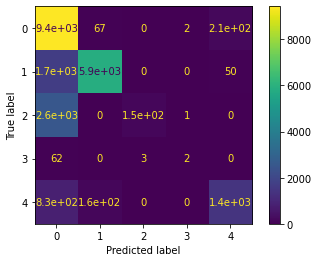

In [ ]:
#confusion matrix
plot_confusion_matrix(random_forest_model, x_test, y0_test)

In [ ]:
save_model(random_forest_model, "random_forest_model.sav")

Model has been saved at:  random_forest_model.sav
